# Evaluate likelihood ratio

In [25]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from scipy.stats import norm
from sklearn.metrics import roc_curve

from inference.utils import s_from_r, shuffle

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Setting

In [26]:
setting = "full"
plot_grads = False

## Data

In [68]:
idx = list(range(50,60))
nrows = len(idx)

In [69]:
filenames = [
    #"carl",
    "alices_full_pre",
]
labels = [
    #"CARL",
    "ALICES",
]
colors = ["red", "green", "yellow"]*4
nmethods = len(filenames)
ncols = len(filenames) + 1

In [70]:
xs = np.load("../data/samples/x_test_{}_point.npy".format(setting))

llrs = np.asarray([np.load("../data/results/llr_{}_grid.npy".format(filename)) for filename in filenames])
if plot_grads:
    grads = np.asarray([np.load("../data/results/grad_x_{}_{}_grid.npy".format(filename, setting))[:100] for filename in filenames])
    grad_logs = grads * xs[np.newaxis, :grads.shape[1]]
    rel_grads = np.abs(grad_logs) / np.sum(np.abs(grad_logs).reshape(grad_logs.shape[0], grad_logs.shape[1], -1), axis=2)[:,:,np.newaxis, np.newaxis]


## Parameter grids

In [71]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

## Plotting options

In [72]:
gradmin, gradmax = -0.1, 0.1
gradrelmax = 0.002
xmin, xmax = 2.3, 3.2

#llrmin, llrmax = -10., 10.
#llr_cmap = "PRGn_r"
#normalize_to_mle = False

llrmin, llrmax = 0., 20.
llr_cmap = "viridis_r"
normalize_to_mle = True


In [73]:
grad_rel = True
alpha_grad = 0.5

if grad_rel:
    grad_rel_color = colorConverter.to_rgba("C1")[:3]

    overlay_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'overlay_cmap',
        [(0., grad_rel_color), (1., grad_rel_color)],
        512
    )
    overlay_cmap._init()
    alphas = np.linspace(0., alpha_grad, overlay_cmap.N + 3)
    overlay_cmap._lut[:,-1] = alphas
    
else:
    pos_grad_color = colorConverter.to_rgba("C0")[:3]
    neg_grad_color = colorConverter.to_rgba("C1")[:3]

    overlay_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'overlay_cmap',
        [(0., neg_grad_color), (0.499, neg_grad_color), (0.501, pos_grad_color), (1., pos_grad_color)],
        512
    )
    overlay_cmap._init()
    alphas = np.asarray(
        list(np.linspace(alpha_grad, 0, overlay_cmap.N // 2 + 1))
        + [0.]
        + list(np.linspace(0., alpha_grad, overlay_cmap.N // 2 + 1))
    )
    overlay_cmap._lut[:,-1] = alphas

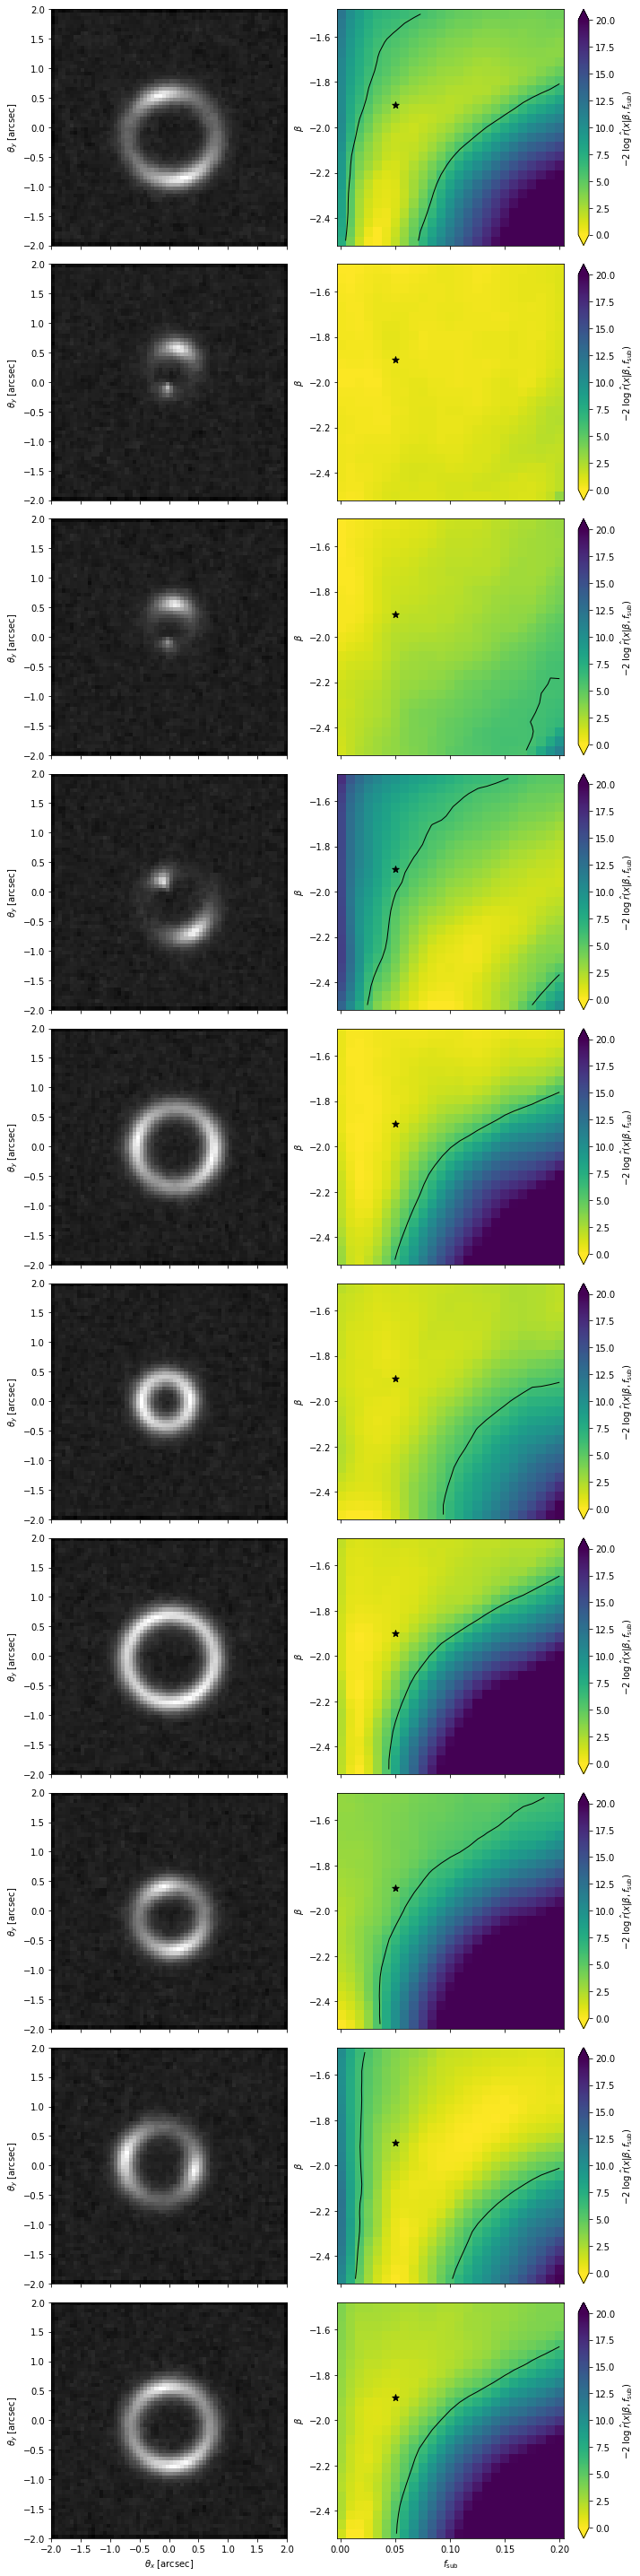

In [74]:
fig = plt.figure(figsize=(5.*ncols, 4.*nrows))
ax_xs = []
ax_rs = []
k_grad = 0

for i in [nrows - 1] + list(range(nrows - 1)):
    i_img = idx[i]

    
    
    # Plot image
    if i == nrows - 1:
        ax_xs = plt.subplot(nrows, ncols, i*ncols + 1)
        ax = ax_xs
    else:
        ax = plt.subplot(nrows, ncols, i*ncols + 1, sharex=ax_xs)

    plt.imshow(
        np.log10(xs[i_img]),
        vmin=xmin,
        vmax=xmax,
        cmap='gist_gray',
        extent=(-2.,2.,-2.,2.),
        origin="lower",
        alpha=1.
    )
    if plot_grads:
        if grad_rel:
            im = plt.imshow(
                rel_grads[k_grad][i_img],
                vmin=0.,
                vmax=gradrelmax,
                cmap=overlay_cmap,
                extent=(-2.,2.,-2.,2.),
                origin="lower",
            )
        else:
            im = plt.imshow(
                grad_logs[k_grad][i_img],
                vmin=gradmin,
                vmax=gradmax,
                cmap=overlay_cmap,
                extent=(-2.,2.,-2.,2.),
                origin="lower",
            )
        cbar = fig.colorbar(im, ax=ax, extend='max')

    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)
    if i == nrows - 1:
        plt.xlabel(r"$\theta_x$ [arcsec]")
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel(r"$\theta_y$ [arcsec]")
    
    
    
    for k in range(nmethods):
        # Plot estimated likelihood ratios
        if i == nrows - 1:
            ax_rs.append(plt.subplot(nrows, ncols, i*ncols + k + 2))
            ax = ax_rs[k]
        else:
            ax = plt.subplot(nrows, ncols, i*ncols + k + 2, sharex=ax_rs[k])
        
        z = -2. * llrs[k][:, i_img]
        if normalize_to_mle:
            z = z - np.min(z)
        z = np.clip(z, llrmin, llrmax)
    
        pcm = ax.pcolormesh(
            alpha_edges,
            beta_edges,
            z.reshape((resolution, resolution)),
            norm=matplotlib.colors.Normalize(vmin=llrmin, vmax=llrmax),
            cmap=llr_cmap
        )
        cbar = fig.colorbar(pcm, ax=ax, extend='both')
        
        cs = plt.contour(
            0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
            0.5 * (beta_edges[1:] + beta_edges[:-1]),
            z.reshape((resolution, resolution)),
            [5.991464547107983],
            colors="black",
            linewidths=1.,
            linestyles=["-"]
        )
        plt.scatter(0.05, -1.9, s=60., color='black', marker='*')

        if i == nrows - 1:
            plt.xlabel(r'$f_{\mathrm{sub}}$')
        else:
            plt.setp(plt.gca().get_xticklabels(), visible=False)
        plt.ylabel(r'$\beta$')
        cbar.set_label(r'$-2\; \log \;\hat{r}(x | \beta, f_{\mathrm{sub}})$')
        plt.xlim(alpha_edges[0], alpha_edges[-1])
        plt.ylim(beta_edges[0], beta_edges[-1])
    
                         
    
plt.tight_layout()
plt.savefig("../figures/predictions_{}.pdf".format(setting))